In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from second.test_kitti import depth_to_3D, init_depth_from_feature

In [3]:
config_path="configs/car.fhd.config"

In [4]:
from second.protos import pipeline_pb2
from google.protobuf import text_format

In [5]:
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)

In [6]:
#config

In [7]:
input_cfg = config.train_input_reader
eval_input_cfg = config.eval_input_reader
model_cfg = config.model.second
train_cfg = config.train_config

In [8]:
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.pytorch.train import build_network

In [9]:
device="cuda"
net = build_network(model_cfg, False).to(device)
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator


In [10]:
dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=True,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
remain number of infos: 3712


In [11]:
from second.sphere.visual import *


In [12]:
def xyz2range(points):
    """ convert points to depth map
        devide evenly, not wokring very well
    """
    print("points shape = ", points.shape)
    x = points[:, 0]  # -71~73
    y = points[:, 1]  # -21~53
    z = points[:, 2]  # -5~2.6
    intensity = points[:, 3]  # 0~1
    # convert xyz to theta-phi-r
    x2y2 = x* x + y*y
    distance = np.sqrt(x2y2 + np.square(z))
#     distance[distance == 0] = 1e-6
    plt.plot(distance )
    plt.show()
    
    thetas = np.arcsin(z / distance)
    phis = np.arcsin(-y / np.sqrt(x2y2))
    # print("min thetas = ", np.min(thetas))
    # print("max theats = ", np.max(thetas))
    # print("min phis = ", np.min(phis))
    # print("max phis = ", np.max(phis))
    delta_phi = np.radians(90./512.)
#     delta_phi = (np.max(phis) - np.min(phis)) / 511.
    # veldyne , resolution 26.8  vertical,
    delta_theta = np.radians(26.8/64)
#     delta_theta = (np.max(thetas) - np.min(thetas)) / 64.
    theta_idx = ((thetas - np.min(thetas)) / delta_theta).astype(int)
    phi_idx = ((phis - np.min(phis)) / delta_phi).astype(int)
    print("theta_idx = ", theta_idx)
    print("phi_idx = ", phi_idx)

    H = 64
    W = 512
    C = 5
    range_map = np.zeros((C,H,W), dtype=float)
    range_map[0, theta_idx,phi_idx] = x
    range_map[1, theta_idx,phi_idx] = y
    range_map[2, theta_idx,phi_idx] = z
    range_map[3, theta_idx,phi_idx] = distance
    range_map[4, theta_idx,phi_idx] = intensity
    return range_map


def xyz2range_v2(points, ith=0, plot_diff=False, visualize=False):
    """
    """
    v_res=26.9/64,
    h_res=90./512.
    x = points[:, 0]  # -71~73
    y = points[:, 1]  # -21~53
    z = points[:, 2]  # -5~2.6
    intensity = points[:, 3]  # 0~1
    
    plot_point_cloud_scatter_2d(x,y)
    plot_point_cloud_scatter_3d(x,y,z)

    
    x2y2 = np.sqrt(np.square(x) + np.square(y))
    distance = np.sqrt(x2y2 + np.square(z))
    # phi
    # arctan2 , and arcsin, almost the same result
    phi = -np.arctan2(y, x)
    # phi_p = np.arcsin(-y / np.sqrt(x ** 2 + y ** 2 ))
    # print("x rad diff", phi, phi_p, np.sum(phi - phi_p))
    angle_diff = np.diff(phi)
    if plot_diff:
        plt.plot(np.diff(phi))
#         plt.savefig(fig_path+"angle_diff_{:d}.jpg".format(ith), dpi=300)
        plt.show()
        plt.clf()
    threshold_angle = np.radians(10)  # huristic
    angle_diff = np.hstack((angle_diff, 0.0001)) # append one
    # new row when diff bigger than threashold
    angle_diff_mask = angle_diff > threshold_angle
    theta_idx = np.cumsum(angle_diff_mask)
    theta_idx[theta_idx >= 64] = 63
    # print("theta max min", theta_idx.max(), theta_idx.min())
    delta_phi = np.radians(90./512.)
    # delta_phi = np.radians((x.max() - x.min()) / 500.) # doenst work. many missing dots horiizontally
    phi_idx = np.floor((phi + np.pi/2) / delta_phi).astype(int)
#    phi_idx -= np.min(phi_idx) # translate to positive
    phi_idx[phi_idx >= 512] = 511
    # x_max = int(360.0 / h_res) #+ 1  # 投影后图片的宽度
    x_max = 512
    if visualize:
        depth_gray = np.interp(distance, (distance.min(), distance.max()), (20,255))
        depth_image = np.zeros((64, 512, 1))
        depth_image[theta_idx, phi_idx, 0] = depth_gray
#        imageio.imwrite(fig_path + 'range_map_v2_{:d}.jpg'.format(ith),
 #           depth_image.astype(np.uint8))
 # 可能有 data loss， 有些数据点被覆盖了。
    depth_map = np.zeros((5, 64, 512), dtype=float) #+255
    depth_map[0, theta_idx, phi_idx] = x
    depth_map[1, theta_idx, phi_idx] = y
    depth_map[2, theta_idx, phi_idx] = z
    depth_map[3, theta_idx, phi_idx] = distance
    depth_map[4, theta_idx, phi_idx] = intensity
    return depth_map



points shape =  (20397, 4)


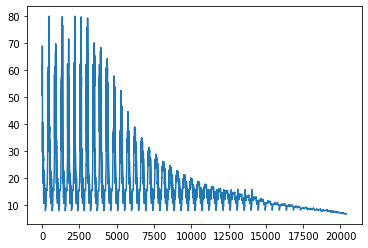

theta_idx =  [40 40 40 ...  0  0  0]
phi_idx =  [224 223 223 ... 227 226 225]
range_map shape (5, 64, 512)
depth =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


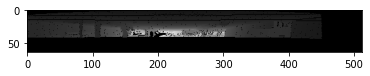

In [13]:
for i in range(0,len(dataset)):
        # break
    if i == 1:
        break
    item = dataset.dataset.get_sensor_data(i+13)
        # print(input_dict)
    points = item['lidar']['points']        
    # imageio.imwrite(fig_path + 'range_map_{:d}.jpg'.format(i),
    # range_map.astype(np.uint8))

    range_map = xyz2range(points)
    print("range_map shape", range_map.shape)
    depth = depth_from_feature_np(range_map, 255)
    print("depth = ", depth)
    plt.imshow(depth, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [14]:
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn
num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
        num_workers=input_cfg.preprocess.num_workers * num_gpu,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

In [15]:
#dataloader.__dir__()


In [16]:
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)


WORKER 0 seed: 1588603473
WORKER 1 seed: 1588603474
WORKER 2 seed: 1588603475
WORKER 3 seed: 1588603476


/home/gx/GitHub/depconv/second/core/preprocess.py:463: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  points[i:i + 1, :3] = points[i:i + 1, :3] @ rot_mat_T[j]
/home/gx/GitHub/depconv/second/core/preprocess.py:463: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  points[i:i + 1, :3] = points[i:i + 1, :3] @ rot_mat_T[j]
/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/typing/npydecl.py:943: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/gx/GitHub/depconv/second/core/preprocess.py:463: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, C))
  points[i:i + 1, :3] = points[i:i + 1, :3] @ rot_mat_T[j]
/home/gx/GitHub/depconv/second/core/preproce

/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "core/geometry.py", line 296:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    cross = 0.0
    for i in range(num_points):
    ^

  @numba.jit
/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:

/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "core/geometry.py", line 296:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    cross = 0.0
    for i in range(num_points):
    ^

  @numba.jit
/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "points_in_convex_polygon_jit" was compiled in object mode without forceobj=True, but has lifted loops.

File "core/geometry.py", line 283:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    # first convert polygon to directed lines
    num_points_of_polygon = polygon.shape[1]
    ^

  state.func_ir.loc))
/home/user/anaconda3/envs/depconv/lib/python3.7/

/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "core/geometry.py", line 283:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    # first convert polygon to directed lines
    num_points_of_polygon = polygon.shape[1]
    ^

  state.func_ir.loc))
/home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "points_in_convex_polygon_jit" was compiled in object mode without forceobj=True, but has lifted loops.

File "core/geometry.py", line 283:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source e

In [17]:
examples[3]

{'voxels': array([[[11.211148  , 17.14814   ,  0.90693367,  0.37      ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]],
 
        [[11.101546  , 17.097363  ,  0.9038628 ,  0.48      ],
         [11.027536  , 17.040789  ,  0.9007919 ,  0.39      ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]],
 
        [[10.929718  , 17.005787  ,  0.897721  ,  0.41      ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]],
 
        ...,
 
        [[ 6.034732  

In [18]:
examples[3]["feature"].shape
# B, C, H, W

(1, 5, 64, 512)

In [19]:
depths = []
for ex in examples:
    feature_np = ex["feature"]
    feature = torch.tensor(feature_np)
    depth = init_depth_from_feature(feature, 128)
    depths.append(depth)

In [20]:
depths[0].shape

torch.Size([1, 64, 512])

In [21]:

def plot_depth(depth):
    """
    depth: int tensor of shape(H, W)
    """
    H, W = depth.shape
    arr = np.asarray(depth)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.show()
    

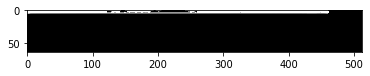

In [22]:
plot_depth(depths[0][0])

In [23]:
for d in depths:
    plot_depth(d[2])

IndexError: index 2 is out of bounds for dimension 0 with size 1

In [ ]:
import torch.nn.functional as F
for d in depths:
    d_ = d
    d_small = F.max_pool2d(d_.float(), 3, padding=1, stride=(1,2)).long()
    plot_depth(d_small[2])

In [ ]:
import torch.nn.functional as F
for d in depths:
    d_ = d
    d_small = F.max_pool2d(d_.float(), 3, padding=1, stride=(1,2)).long()
    d_small_2 = F.max_pool2d(d_small.float(), 3, padding=1, stride=(1,2)).long()
    
    plot_depth(d_small_2[2]//2)